In [17]:
import qubic.toolchain as tc
import qubic.rpc_client as rc
import qubitconfig.qchip as qc
from distproc.hwconfig import FPGAConfig, load_channel_configs
import chipcalibration.config as cfg
import numpy as np
import matplotlib.pyplot as plt
import qubic.state_disc as sd
from chipcalibration import vna as vn
import qubic.job_manager as jm

## Load Configs and Define Circuit

define FPGA config; this has timing information for the scheduler. For now it is fine to use the following hardcoded config

In [18]:
fpga_config = FPGAConfig()
channel_configs = load_channel_configs('channel_config_hw.json')
qchip = qc.QChip('qubitcfg.json')
# qchip.cfg_dict

### Define a circuit to generate pulses on Q3

For Q3, the frequency is 400MHz as defined in qubic.json. Also, Q3.qdrv is connected to DAC_228_1, and Q3.rdlo -> ADC_227_0

In [19]:
circuit_q3 = [
    # play a pi pulse on Q3
    {'name': 'pulse', 'phase': 0, 'freq': 400e6, 'amp': 0.90, 'twidth': 64e-9,
     'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
     'dest': 'Q3.qdrv'},
    
    {'name': 'delay', 't': 100.0715e-9},
    
    {'name': 'pulse', 'phase': 0, 'freq': 400e6, 'amp': 0.50, 'twidth': 64e-9,
     'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
     'dest': 'Q3.qdrv'},
    
    {'name': 'delay', 't': 100.0715e-9},
    
    {'name': 'pulse', 'phase': 0, 'freq': 400e6, 'amp': 0.90, 'twidth': 64e-9,
     'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
     'dest': 'Q3.qdrv'},
    
    {'name': 'delay', 't': 100.0715e-9},

    # play a pi/2 pulse on Q6
    {'name': 'pulse', 'phase': 0, 'freq': 5.7e9, 'amp': 0.50, 'twidth': 32e-9,
    'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
    'dest': 'Q6.qdrv'}

]

In [20]:
compiled_q3_prog = tc.run_compile_stage(circuit_q3, fpga_config, qchip)
compiled_q3_prog.program
raw_asm_q3 = tc.run_assemble_stage(compiled_q3_prog, channel_configs)

In [21]:
runner = rc.CircuitRunnerClient(ip='localhost', port=9095)

Submit the circuit to the server, and collect 1 shot. The runner will run the currently loaded program (or a batch of circuits) and acquire the results from acq buf or acc buf.

In [22]:
acq_data_q3 = runner.load_and_run_acq(raw_asm_q3, n_total_shots=1, acq_chans={'0':0,'1':1}, trig_delay=0e-9)

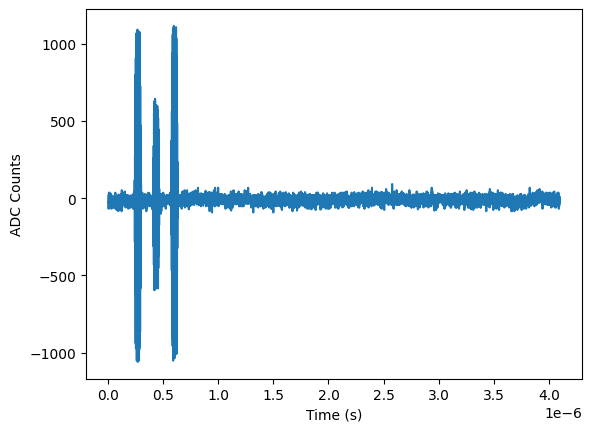

In [23]:
# # plt.figure()

plt.xlabel('Time (s)')
plt.ylabel('ADC Counts')
plt.plot(np.arange(0,acq_data_q3['1'].shape[1]*0.5e-9,0.5e-9)[10:], np.average(acq_data_q3['1'],axis=0)[10:])


In [24]:
# %matplotlib notebook
# # plt.figure()
# plt.xlabel('Time (s)')
# plt.ylabel('ADC Counts')
# plt.plot(np.arange(0,acq_data['1'].shape[1]*0.5e-9,0.5e-9)[10:], np.average(acq_data['1'],axis=0)[10:])

# Data setup
time = np.arange(0, acq_data_q3['1'].shape[1] * 0.5e-9, 0.5e-9)[10:]
adc_counts = np.average(acq_data_q3['1'], axis=0)[10:]

import plotly.graph_objects as go

# Interactive Plotly plot
fig = go.Figure(data=go.Scatter(x=time, y=adc_counts, mode='lines'))
fig.update_layout(
    title="Interactive Plot with Plotly",
    xaxis_title="Time (s)", yaxis_title="ADC Counts on Q3"
    )

# Show interactive plot with zoom and scale controls
fig.show()

### Generate puleses on Q1, which is 4.6GHz

For Q1, the frequency is 4675138775.442301 (4.6 GHz), and the output of the DAC channel for Q1, which is  **Q1.qdrv** on core_ind 4, elem_ind 0, **DAC_228_3**, must be connected to **Q1 rdlo**, which is core 4, elem_id 2, connected to **ADC_227_2**.


In [25]:
X90_Q1 = {'name': 'pulse',                     # generic pulse
          'phase': 0,                          # phase starts at 0
          'freq': 5000e6,                  # carrier frequence in Hz
          'amp': 0.48150320341813146,          # amplitude applied to envelope
          'twidth': 2.4e-08,                   # duration in seconds
          'env': {                             # the pulse envelope
              'env_func': 'cos_edge_square',   # function describing the envelope
              'paradict': {                    # parameters input to env_func
                  'ramp_fraction': 0.25        # fraction of the square to be
              }                                #  smoothed by the cosine
          },
          'dest': 'Q1.qdrv'                    # channel to play the pulse on, here
                                               #  the drive of qubit 1
}

circuit_q1 = [
    # Passive reset (this assumes the qubit T1 is roughy 100us.
    {'name': 'delay', 't': 500.e-6}, 
    # Our X90 pulse on Q1, defined above.
    X90_Q1,
    # Another X90, to achieve an X180, ie. a bit flip.
    X90_Q1,
    # An additional delay of 20ns
    {'name': 'delay', 't': 100.e-9},
    # A measurement of Q1, defined qubitcfg.json, just like the above
    # X90 was.
    {'name': 'read', 'qubit': 'Q1'},
]

In [26]:
compiled_q1_prog = tc.run_compile_stage(circuit_q1, fpga_config, qchip)
compiled_q1_prog.program

{('Q1.qdrv', 'Q1.rdrv', 'Q1.rdlo'): [{'op': 'phase_reset'},
  {'op': 'pulse',
   'freq': 5000000000.0,
   'phase': 0,
   'amp': 0.48150320341813146,
   'env': {'env_func': 'cos_edge_square',
    'paradict': {'ramp_fraction': 0.25, 'twidth': 2.4e-08}},
   'start_time': 250005,
   'dest': 'Q1.qdrv'},
  {'op': 'pulse',
   'freq': 5000000000.0,
   'phase': 0,
   'amp': 0.48150320341813146,
   'env': {'env_func': 'cos_edge_square',
    'paradict': {'ramp_fraction': 0.25, 'twidth': 2.4e-08}},
   'start_time': 250017,
   'dest': 'Q1.qdrv'},
  {'op': 'pulse',
   'freq': 6558671869.775688,
   'phase': 0.0,
   'amp': 0.018964980535141,
   'env': {'env_func': 'cos_edge_square',
    'paradict': {'ramp_fraction': 0.25, 'twidth': 2e-06}},
   'start_time': 250079,
   'dest': 'Q1.rdrv',
   'tag': 'Q1read'},
  {'op': 'pulse',
   'freq': 6558671869.775688,
   'phase': 0,
   'amp': 1.0,
   'env': {'env_func': 'square',
    'paradict': {'phase': 0.0, 'amplitude': 1.0, 'twidth': 2e-06}},
   'start_time': 2

In [27]:
raw_asm_q1 = tc.run_assemble_stage(compiled_q1_prog, channel_configs)

In [28]:
# acq_data_q1 = runner.load_and_run_acq(raw_asm_q1, n_total_shots=1, trig_delay=131.0715e-6)
acq_data_q1 = runner.load_and_run_acq(
    raw_asm_q1,
    n_total_shots=1,
    acq_chans={'0':0,'1':1},
    trig_delay=0e-9
    )

In [29]:
# use 0.2e-9 since the frequency is, time scale is 2 / 5000e6 = 0.4e-10
time = np.arange(0, acq_data_q1['1'].shape[1] * 0.4e-10, 0.4e-10)[10:]
adc_counts = np.average(acq_data_q1['1'], axis=0)[10:]

import plotly.graph_objects as go

# Interactive Plotly plot
fig = go.Figure(data=go.Scatter(x=time, y=adc_counts, mode='lines'))
fig.update_layout(
    title="Interactive Plot with Plotly",
    xaxis_title="Time (s)", yaxis_title="ADC Counts on Q1"
    )

# Show interactive plot with zoom and scale controls
fig.show()